In [3]:
import imblearn as imb
import numpy as np
import pandas as pd

In [4]:
from sklearn.datasets import make_classification

random_seed = 42

X, y = make_classification(
    n_samples=15000,
    n_features=5,
    n_redundant=0,
    n_clusters_per_class=2,
    weights=[0.75],
    flip_y=0,
    random_state=random_seed,
)

columns = [f"feature_{i}" for i in range(1, X.shape[1] + 1)]
df = pd.DataFrame(data=X, columns=columns)
df["target"] = y

df

,feature_1,feature_2,feature_3,feature_4,feature_5,target
0,0.806851,0.264305,-0.784994,-1.333940,-0.348174,0
1,0.899865,-1.150787,0.064603,1.627266,-2.275097,0
2,-0.863205,-1.098121,-0.759703,0.714309,0.688674,0
3,-0.969464,-0.278292,-1.011033,0.730749,-2.024265,0
4,0.830337,-0.028375,-0.557634,0.355968,-0.422009,0
...,...,...,...,...,...,...
14995,-0.398952,-0.833110,1.035855,1.840583,1.248318,1
14996,-0.874915,0.668801,-0.896691,-0.804652,-2.314407,0
14997,-1.939143,0.999973,-2.000581,0.495230,0.344745,0
14998,-0.039921,0.088237,-0.116877,-1.079818,1.369312,0


In [5]:
print("Imbalanced Dataset Information:")
print("Number of samples:", df.shape[0])
print("Number of features:", df.shape[1] - 1) 
print("Number of class 0 samples:", df[df["target"] == 0].shape[0])
print("Number of class 1 samples:", df[df["target"] == 1].shape[0])
print("Class distribution:", df["target"].value_counts())


Imbalanced Dataset Information:
Number of samples: 15000
Number of features: 5
Number of class 0 samples: 11250
Number of class 1 samples: 3750
Class distribution: target
0    11250
1     3750
Name: count, dtype: int64


In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score

model = LogisticRegression()

kf = KFold(n_splits=5, shuffle=True, random_state=42)

def kfoldmetrics(scoring):
    accuracy_scores = cross_val_score(model, X=X, y=y, cv=kf, scoring=scoring)

    for i, scores in enumerate(accuracy_scores, 1):
        print(f"Fold {i} : Accuracy - {scores:.4f}")

    print(f"Average accuracy - {accuracy_scores.mean():.4f}")
    



In [7]:
kfoldmetrics("accuracy")

Fold 1 : Accuracy - 0.9287
Fold 2 : Accuracy - 0.9143
Fold 3 : Accuracy - 0.9220
Fold 4 : Accuracy - 0.9253
Fold 5 : Accuracy - 0.9240
Average accuracy - 0.9229


In [8]:
kfoldmetrics("precision")

Fold 1 : Accuracy - 0.8978
Fold 2 : Accuracy - 0.8676
Fold 3 : Accuracy - 0.8809
Fold 4 : Accuracy - 0.8569
Fold 5 : Accuracy - 0.8750
Average accuracy - 0.8757


In [9]:
kfoldmetrics("recall")

Fold 1 : Accuracy - 0.8197
Fold 2 : Accuracy - 0.7794
Fold 3 : Accuracy - 0.8026
Fold 4 : Accuracy - 0.8206
Fold 5 : Accuracy - 0.8062
Average accuracy - 0.8057


In [11]:
kfoldmetrics("f1")

Fold 1 : Accuracy - 0.8570
Fold 2 : Accuracy - 0.8212
Fold 3 : Accuracy - 0.8399
Fold 4 : Accuracy - 0.8384
Fold 5 : Accuracy - 0.8392
Average accuracy - 0.8391


In [13]:
from sklearn.metrics import make_scorer, matthews_corrcoef

scorer = make_scorer(matthews_corrcoef)
kfoldmetrics(scorer)

Fold 1 : Accuracy - 0.8111
Fold 2 : Accuracy - 0.7669
Fold 3 : Accuracy - 0.7900
Fold 4 : Accuracy - 0.7902
Fold 5 : Accuracy - 0.7907
Average accuracy - 0.7898


In [14]:
from sklearn.metrics import make_scorer, cohen_kappa_score

scorer = make_scorer(cohen_kappa_score)

kfoldmetrics(scorer)

Fold 1 : Accuracy - 0.8096
Fold 2 : Accuracy - 0.7650
Fold 3 : Accuracy - 0.7885
Fold 4 : Accuracy - 0.7899
Fold 5 : Accuracy - 0.7896
Average accuracy - 0.7885


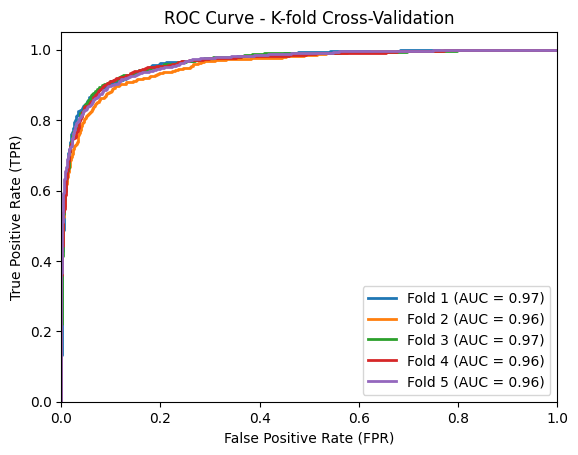

In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

for i, (j, k)  in enumerate(kf.split(X), 1):
    xtrain, xtest = X[j], X[k]
    ytrain, ytest = y[j], y[k]

    model.fit(xtrain, ytrain)
    yscores = model.predict_proba(xtest)[:, 1]

    fpr, tpr, thresholds = roc_curve(ytest, yscores)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Fold {i} (AUC = {roc_auc:.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve - K-fold Cross-Validation")
plt.legend(loc="lower right")
plt.show()

In [28]:
from imblearn.over_sampling import RandomOverSampler

mcc_scorer = make_scorer(matthews_corrcoef)
kappa_scorer = make_scorer(cohen_kappa_score)


def sampling_strategy(sampler):
    for i, (train_index, test_index) in enumerate(kf.split(X), 1):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        X_train_resampled, y_train_resampled = sampler.fit_resample(X_train, y_train)

        model.fit(X_train_resampled, y_train_resampled)

        mcc = mcc_scorer(model, X_test, y_test)
        kappa = kappa_scorer(model, X_test, y_test)

        print(f"Fold {i}, MCC: {mcc:.4f}, Cohen's Kappa: {kappa:.4f}")

In [29]:
oversampler = RandomOverSampler(random_state=42)
sampling_strategy(oversampler)

Fold 1, MCC: 0.7739, Cohen's Kappa: 0.7704
Fold 2, MCC: 0.7459, Cohen's Kappa: 0.7419
Fold 3, MCC: 0.7722, Cohen's Kappa: 0.7675
Fold 4, MCC: 0.7473, Cohen's Kappa: 0.7380
Fold 5, MCC: 0.7508, Cohen's Kappa: 0.7443


In [30]:
from imblearn.under_sampling import RandomUnderSampler

undersampler = RandomUnderSampler(random_state=42)
sampling_strategy(undersampler)

Fold 1, MCC: 0.7732, Cohen's Kappa: 0.7697
Fold 2, MCC: 0.7449, Cohen's Kappa: 0.7410
Fold 3, MCC: 0.7702, Cohen's Kappa: 0.7650
Fold 4, MCC: 0.7481, Cohen's Kappa: 0.7385
Fold 5, MCC: 0.7544, Cohen's Kappa: 0.7484


In [31]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
sampling_strategy(smote)

Fold 1, MCC: 0.7793, Cohen's Kappa: 0.7763
Fold 2, MCC: 0.7459, Cohen's Kappa: 0.7422
Fold 3, MCC: 0.7722, Cohen's Kappa: 0.7675
Fold 4, MCC: 0.7543, Cohen's Kappa: 0.7464
Fold 5, MCC: 0.7560, Cohen's Kappa: 0.7504


In [32]:
from imblearn.over_sampling import BorderlineSMOTE

borderline_smote = BorderlineSMOTE(random_state=42)
sampling_strategy(borderline_smote)

Fold 1, MCC: 0.7122, Cohen's Kappa: 0.6938
Fold 2, MCC: 0.6927, Cohen's Kappa: 0.6754
Fold 3, MCC: 0.7079, Cohen's Kappa: 0.6868
Fold 4, MCC: 0.6815, Cohen's Kappa: 0.6531
Fold 5, MCC: 0.6973, Cohen's Kappa: 0.6759


In [33]:
from imblearn.over_sampling import ADASYN

andasyn = ADASYN(random_state=42)
sampling_strategy(andasyn)

Fold 1, MCC: 0.7113, Cohen's Kappa: 0.6878
Fold 2, MCC: 0.6789, Cohen's Kappa: 0.6594
Fold 3, MCC: 0.6900, Cohen's Kappa: 0.6647
Fold 4, MCC: 0.6683, Cohen's Kappa: 0.6353
Fold 5, MCC: 0.6890, Cohen's Kappa: 0.6658


In [36]:
from imblearn.under_sampling import NearMiss

near_miss = NearMiss(version=3, sampling_strategy=0.5)
sampling_strategy(near_miss)

/home/shusrith/.local/lib/python3.11/site-packages/imblearn/under_sampling/_prototype_selection/_nearmiss.py:203: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  warnings.warn(
/home/shusrith/.local/lib/python3.11/site-packages/imblearn/under_sampling/_prototype_selection/_nearmiss.py:203: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  warnings.warn(
/home/shusrith/.local/lib/python3.11/site-packages/imblearn/under_sampling/_prototype_selection/_nearmiss.py:203: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  warnings.warn(
/home/shusrith/.local/lib/python3.11/site-packages/imblearn/under_sampling/_prototype_se

Fold 1, MCC: 0.8016, Cohen's Kappa: 0.8016
Fold 2, MCC: 0.7591, Cohen's Kappa: 0.7591
Fold 3, MCC: 0.7950, Cohen's Kappa: 0.7949
Fold 4, MCC: 0.7772, Cohen's Kappa: 0.7759
Fold 5, MCC: 0.7721, Cohen's Kappa: 0.7716


/home/shusrith/.local/lib/python3.11/site-packages/imblearn/under_sampling/_prototype_selection/_nearmiss.py:203: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  warnings.warn(


In [37]:
from imblearn.under_sampling import CondensedNearestNeighbour

cnn = CondensedNearestNeighbour(random_state=42)
sampling_strategy(cnn)

KeyboardInterrupt: 

In [38]:
from imblearn.under_sampling import TomekLinks

tl = TomekLinks()
sampling_strategy(tl)

Fold 1, MCC: 0.8035, Cohen's Kappa: 0.8030
Fold 2, MCC: 0.7717, Cohen's Kappa: 0.7710
Fold 3, MCC: 0.7942, Cohen's Kappa: 0.7937
Fold 4, MCC: 0.7864, Cohen's Kappa: 0.7864
Fold 5, MCC: 0.7909, Cohen's Kappa: 0.7907


In [39]:
from imblearn.under_sampling import EditedNearestNeighbours

enn = EditedNearestNeighbours()
sampling_strategy(enn)

Fold 1, MCC: 0.7988, Cohen's Kappa: 0.7987
Fold 2, MCC: 0.7633, Cohen's Kappa: 0.7629
Fold 3, MCC: 0.7927, Cohen's Kappa: 0.7920
Fold 4, MCC: 0.7749, Cohen's Kappa: 0.7715
Fold 5, MCC: 0.7717, Cohen's Kappa: 0.7705


In [41]:
from imblearn.under_sampling import OneSidedSelection, NeighbourhoodCleaningRule

for i, (train_index, test_index) in enumerate(kf.split(X), 1):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    oss = OneSidedSelection()
    X_train_resampled, y_train_resampled = oss.fit_resample(X_train, y_train)

    ncr = NeighbourhoodCleaningRule()
    X_train_resampled, y_train_resampled = ncr.fit_resample(X_train_resampled, y_train_resampled)

    model.fit(X_train_resampled, y_train_resampled)

    mcc = mcc_scorer(model, X_test, y_test)
    kappa = kappa_scorer(model, X_test, y_test)

    print(f"Fold {i}, MCC: {mcc:.4f}, Cohen's Kappa: {kappa:.4f}")

Fold 1, MCC: 0.8009, Cohen's Kappa: 0.8007
Fold 2, MCC: 0.7636, Cohen's Kappa: 0.7631
Fold 3, MCC: 0.7961, Cohen's Kappa: 0.7954
Fold 4, MCC: 0.7774, Cohen's Kappa: 0.7744
Fold 5, MCC: 0.7687, Cohen's Kappa: 0.7676


In [42]:
from imblearn.combine import SMOTETomek

st = SMOTETomek(random_state=42)
sampling_strategy(st)

Fold 1, MCC: 0.7801, Cohen's Kappa: 0.7774
Fold 2, MCC: 0.7476, Cohen's Kappa: 0.7439
Fold 3, MCC: 0.7729, Cohen's Kappa: 0.7683
Fold 4, MCC: 0.7563, Cohen's Kappa: 0.7486
Fold 5, MCC: 0.7563, Cohen's Kappa: 0.7510


In [43]:
from imblearn.pipeline import make_pipeline, Pipeline

for i, (train_index, test_index) in enumerate(kf.split(X), 1):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    pipeline = make_pipeline(
        RandomOverSampler(random_state=42),
        RandomUnderSampler(random_state=42),
        LogisticRegression(),
    )

    pipeline.fit(X_train, y_train)

    mcc = mcc_scorer(model, X_test, y_test)
    kappa = kappa_scorer(model, X_test, y_test)

    print(f"Fold {i}, MCC: {mcc:.4f}, Cohen's Kappa: {kappa:.4f}")

Fold 1, MCC: 0.7797, Cohen's Kappa: 0.7769
Fold 2, MCC: 0.7487, Cohen's Kappa: 0.7451
Fold 3, MCC: 0.7725, Cohen's Kappa: 0.7681
Fold 4, MCC: 0.7609, Cohen's Kappa: 0.7538
Fold 5, MCC: 0.7563, Cohen's Kappa: 0.7510
